In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.stats import norm 

In [2]:
def regenerate_fig_2b():
    V = np.arange(-80, -50, 1)
    V_rest = -70.0*np.ones((len(V)),)
    k = 0.3
    n = 2.0
    R = k*np.power(np.maximum(0.0, np.floor(V-V_rest)), n)
    
    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title('single-neuron I/O function (Figure 2, B)', fontsize=12)
    plt.xlabel(' Vm [mV]', fontsize=12)
    plt.ylabel('rate [Hz]', fontsize=12)
    plt.plot(V, R)

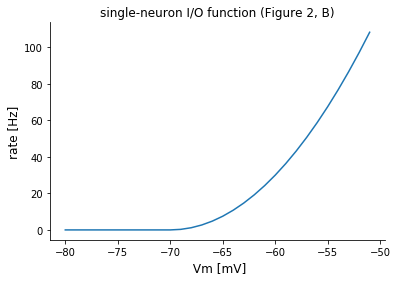

In [3]:
regenerate_fig_2b()

In [4]:
def generate_Weiner_process(m, n_steps, dt, scale=0.1):
    """
    Generate m Weiner process 
    """
    r = norm.rvs(size=(m, n_steps), scale = scale)
    out = np.cumsum(r, axis=-1)
    return out

In [5]:
V_rest = -70.0 # mV, resting membrane potential

tau_E = 20.0 # ms, E neuron time constant 
tau_I = 10.0 # ms, I neuron time constant 

W_EE = 1.25 # mV*s, connection weight 
W_IE = 1.2 # mV*s, connection weight
W_EI = 0.65 # mV*s, connection weight
W_II = 0.5 # mV*s, connection weight

b = 2.0 # mV, input baseline

sigma_0E = 0.2 # mV, noise standard deviation 
sigma_0I = 0.1 # mV, noise standard deviation 

tau_noise = 50.0 # ms, noise correlation time constant 

k = 0.3 # mV^-n*s^-1, nonlinearity gain 
n = 2 # nonlinearity exponent 

dt = 0.1 # time step

In [6]:
# checked Nov 21st

sigma_noise = np.zeros((2,2))
sigma_noise[0,0] = (np.power(sigma_0E,2))*(1+tau_E/tau_noise)
sigma_noise[1,1] = (np.power(sigma_0I,2))*(1+tau_I/tau_noise)

In [7]:
W = np.array([[W_EE, -W_EI],
            [W_IE, -W_II]])

In [8]:
tau = [tau_E, tau_I]

In [9]:
def generate_noise(N, 
                   n_step, 
                   scale=0.1,
                   tau_noise = tau_noise,
                   sigma_noise = sigma_noise):
    """
    Generate input noise for N units, each unit for n_steps
    """
    # record 
    noise_list = np.empty((N, n_step))
    
    # initialize 
    noise = np.zeros((N,))
    
    r = norm.rvs(size=(N, n_step), scale = scale)
    
    # pregenerate Weiner process 
    #Weiner = generate_Weiner_process(N, n_step, dt, scale=scale)
    
    for i_step in range(n_step):
        
        # update noise 
        # checked Nov 20th 
        d_noise = (-noise*dt + (np.sqrt(2*tau_noise*sigma_noise)).dot(r[:,i_step]))/tau_noise
        noise = noise + d_noise
        noise_list[:,i_step] = noise
        
    return noise_list

In [10]:
def simulate(V_rest = V_rest, 
             N = 2, 
             n_step = 10000, # default simulate for 1s
             start_step = 0,
             dt = 0.1, 
             h = b, 
             W = W, 
             k = k, 
             n = n,
             tau = tau,
             noise_scale=1.0,
             V_init = None):
    """
    V_rest: resting potential 
    N: total number of neurons 
    n_step: total simulation steps 
    dt: simulation time step 
    h: constant input 
    W: exc and inh weights
    k,n: parameter for r supralinear function
    tau: list of tau for corresponding units 
    """
    
    # Initialization
    if V_init is None: 
        V = V_rest * np.ones((N,)) # start at resting potential 
    else: 
        V = V_init
    V_rest_vec = V_rest*np.ones((N,))
    H = h*np.ones((N,))
    noise = np.zeros((N,))
    
    # record 
    record_step = n_step - start_step
    V_list = np.empty((N, record_step))
    noise_record_list = np.empty((N, record_step))
    r_list = np.empty((N, record_step))
    H_list = np.empty((N, record_step))
    
    # pre-generate noise 
    noise_list = generate_noise(N, n_step, scale=noise_scale)
    
    for i_step in range(n_step):
        
        # get noise 
        noise = noise_list[:,i_step]
        
        # get R 
        # checked Nov 20th 
        R = k*np.power(np.maximum(0.0, np.floor(V-V_rest)), n)
        
        # update membrane potential 
        dv = np.divide(dt*(-V + V_rest_vec + H + noise + W.dot(R)), tau)
        # dv = np.divide(dt*(-V + V_rest_vec + H + noise), tau) # verified for the case of feedforward, Nov 21st
        # dv = np.divide(dt*(-V + V_rest_vec + H + W.dot(R)), tau) # verified for the case of no noise, Nov 21st 
        V = V + dv 
        
        # record 
        if i_step >= start_step: 
            r_list[:,i_step-start_step] = R
            V_list[:,i_step-start_step] = V
            noise_record_list[:,i_step-start_step] = noise
            H_list[:,i_step-start_step] = H
        
    V_last = V
        
    return V_list, r_list, noise_record_list, H_list, V_last

In [17]:
def regenerate_figure_2c():
    
    H_total_list = np.empty((2, 100000))
    V_total_list = np.empty((2, 100000))
    
    for i in range(10):
        
        if i==0: 
            [V_list, r_list, noise_list, H_list, V_last]  = simulate(h=0.0)
        elif i ==1: 
            [V_list, r_list, noise_list, H_list, V_last]  = simulate(h=0.0, V_init = V_last)
        elif i<6:
            [V_list, r_list, noise_list, H_list, V_last]  = simulate(h=2.0, V_init = V_last)
        else:
            [V_list, r_list, noise_list, H_list, V_last]  = simulate(h=15.0, V_init = V_last)
        
        # record 
        H_total_list[:,i*10000:(i+1)*10000] = H_list 
        V_total_list[:,i*10000:(i+1)*10000] = V_list 
        
    T_list = np.arange(0,10,0.0001)
        
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,4))
    
    ax1.plot(T_list, V_total_list[0], label='exc', color='red')
    ax1.plot(T_list, V_total_list[1], label='inh', color='blue')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_ylabel(' V_E/I [mV]', fontsize=12)
    ax1.legend()

    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.plot(T_list, H_total_list[0])
    ax2.set_ylabel('h [mV]', fontsize=12)
    plt.xlabel('time (s)', fontsize=12)
    
    return H_total_list, V_total_list

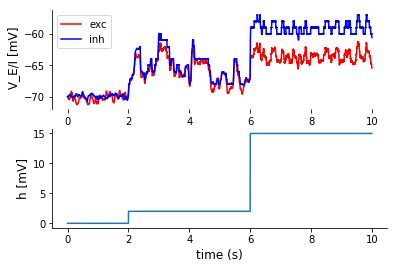

In [18]:
[H_total_list, V_total_list] = regenerate_figure_2c()

In [46]:
def simulate_figure_2d(h_max = 20,
                        n_trials = 5,
                        n_step = 20000,
                        start_step = 2000):
    """
    Regenerate figure 2D 
    
    Arguments 
    ---------
    n_trials: number of simulations to average over, 500 in the paper 
    """
    
    # get range of h to test
    h_range = np.arange(h_max+1)
    
    # record 
    V_std_list = np.empty((n_trials, h_max+1, 3))
    V_mean_list = np.empty((n_trials, h_max+1, 3))
    r_mean_list = np.empty((n_trials, h_max+1, 3))
    
    # simulate 
    for i_h, h in enumerate(h_range):
        
        for i_trial in range(n_trials):
            
            # simulate 
            [V_list, r_list, noise_list, H_list, V_last]  = simulate(n_step=n_step, 
                                                                     h=h, 
                                                                     W = np.array([[W_EE, -W_EI],[W_IE, -W_II]]),
                                                                     start_step=start_step) # allow for 2s to set to stable
            
            # record 
            V_std_list[i_trial][i_h][:2] = np.std(V_list, axis=1)
            V_mean_list[i_trial][i_h][:2] = np.mean(V_list, axis=1)
            r_mean_list[i_trial][i_h][:2] = np.mean(r_list, axis=1)
            
            # simulate for feedforward 
            [V_list, r_list, noise_list, H_list, V_last]  = simulate(n_step=n_step, 
                                                                     h=h, 
                                                                     W=np.zeros((2,2)),
                                                                     start_step=start_step)
            V_std_list[i_trial][i_h][2] = np.std(V_list[0])
            V_mean_list[i_trial][i_h][2] = np.mean(V_list[0])
            r_mean_list[i_trial][i_h][2] = np.mean(r_list[0])
            
    return V_std_list, V_mean_list, r_mean_list

In [43]:
def plot_figure_2d_subplot(ax, data_list, error_list, ylabel):
    h_range = np.arange(len(data_list))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    color_list = ['red', 'blue', 'gray']
    for i in range(3):
        ax.plot(h_range,data_list[:,i], color=color_list[i])
        ax.fill_between(h_range, 
                        data_list[:,i]-error_list[:,i],
                        data_list[:,i]+error_list[:,i],
                       alpha=0.3,
                       color=color_list[i])
    ax.set_ylabel(ylabel)

In [51]:
def regenerate_figure_2d(h_max=20,
                        n_trials=10):
    
    [V_std_list, V_mean_list, r_mean_list] = simulate_figure_2d(h_max=h_max, 
                                                                n_trials=n_trials)
    
    V_std_mean = np.mean(V_std_list, axis=0)
    V_mean_mean = np.mean(V_mean_list, axis=0)
    r_mean_mean = np.mean(r_mean_list, axis=0)

    V_std_std = np.std(V_std_list, axis=0)
    V_mean_std = np.std(V_mean_list, axis=0)
    r_mean_std = np.std(r_mean_list, axis=0)
    
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,6))
    plot_figure_2d_subplot(ax=ax1,
                           data_list=r_mean_mean, 
                           error_list=r_mean_std,
                           ylabel='mean rate [Hz]')
    plot_figure_2d_subplot(ax=ax2,
                           data_list=V_mean_mean, 
                           error_list=V_mean_std,
                           ylabel='mean V_E/I [mV]')
    plot_figure_2d_subplot(ax=ax3,
                           data_list=V_std_mean, 
                           error_list=V_std_std,
                           ylabel='V_E/I std [mV]')
    plt.xlabel('input h [mV]')
    
    np.savez('figure_2d_data',
            V_std_list = V_std_list, 
            V_mean_list = V_mean_list,
            r_mean_list = r_mean_list)

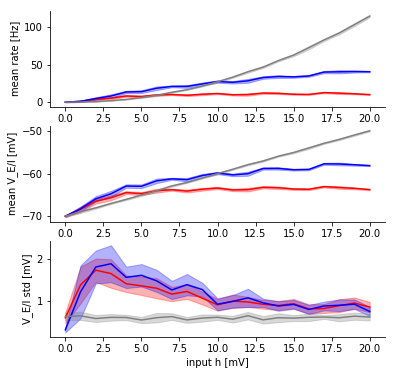

In [52]:
regenerate_figure_2d()